# NAME

## Description

# Import and Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#export 
from exp.nb_CustomDataLoader import Detection_dataset
from exp.nb_Evaluation import load_model, preprocess_image, visualize_yolo

In [3]:
import os, sys
base = '/Users/ckh/Documents/Poladrone/nb'
# base = 'D:/YoloV5_Hui/poladrone_nb'
sys.path.append(base + '/ref/pytorchYOLOv4')

In [4]:
#export 
from ref.pytorchYOLOv4.models import *
import torch.nn as nn

In [5]:
import torch.onnx

# Function

In [6]:
class Yolov4_temp(nn.Module):
    def __init__(self, yolov4conv137weight=None, n_classes=80, inference=False):
        super().__init__()

        output_ch = (4 + 1 + n_classes) * 3

        # backbone
        self.down1 = DownSample1()
        self.down2 = DownSample2()
        self.down3 = DownSample3()
        self.down4 = DownSample4()
        self.down5 = DownSample5()
        # neck
        self.neek = Neck(inference)
        # yolov4conv137
        if yolov4conv137weight:
            _model = nn.Sequential(self.down1, self.down2, self.down3, self.down4, self.down5, self.neek)
            pretrained_dict = torch.load(yolov4conv137weight)

            model_dict = _model.state_dict()
            # 1. filter out unnecessary keys
            pretrained_dict = {k1: v for (k, v), k1 in zip(pretrained_dict.items(), model_dict)}
            # 2. overwrite entries in the existing state dict
            model_dict.update(pretrained_dict)
            _model.load_state_dict(model_dict)
        
        # head
        self.head = Yolov4Head(output_ch, n_classes, inference)


    def forward(self, input):
        d1 = self.down1(input)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)

        x20, x13, x6 = self.neek(d5, d4, d3)

        output = self.head(x20, x13, x6)
        return output


# Main

## Model Full

In [20]:
model_path = "./weight/Yolov4_epoch1707.pth"
torch_model = load_model(model_path)

Load: ./weight/Yolov4_epoch1707.pth | Device: cpu


In [21]:
if isinstance(torch_model, torch.nn.DataParallel):
    torch_model = torch_model.module

## Model Partial

In [7]:
n_classes = 1
weight_path = "./weight/Yolov4_epoch1707.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
model = Yolov4_temp(None, n_classes=n_classes, inference=True)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load(weight_path, map_location=device))

if isinstance(model, torch.nn.DataParallel):
    torch_model = model.module
torch_model.eval()

print()

In [8]:
batch_size = 1
x = torch.randn(batch_size, 3, 416, 416, requires_grad=False)
torch_out = torch_model(x)

torch_out.shape

torch.Size([1, 10647, 5])

In [9]:
# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "yolo4_1.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

/Users/ckh/anaconda3/lib/python3.6/site-packages/numpy/core/function_base.py:113: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  num = operator.index(num)
/Users/ckh/Documents/Poladrone/nb/ref/pytorchYOLOv4/tool/yolo_layer.py:194: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  bx = bxy[:, ii] + torch.tensor(grid_x, device=device, dtype=torch.float32) # grid_x.to(device=device, dtype=torch.float32)
/Users/ckh/Documents/Poladrone/nb/ref/pytorchYOLOv4/tool/yolo_layer.py:196: TracerWarning: torch.tensor results are registe

In [10]:
## Onnx
import onnx
import onnxruntime

In [11]:
onnx_model = onnx.load("yolo4_1.onnx")
onnx.checker.check_model(onnx_model)

In [12]:

ort_session = onnxruntime.InferenceSession("yolo4_1.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [13]:
np.array(ort_outs[0]).shape, torch_out.shape

((1, 10647, 5), torch.Size([1, 10647, 5]))

# Result

In [16]:
from config.config import Cfg

data_list = "/Users/ckh/OneDrive - Default Directory/Hui_Wan/npt_test.txt"
val_dataset = Detection_dataset(data_list, Cfg, val=True, val_keep_size=True)


In [17]:
img_raw, gt = val_dataset[0]
img_in = preprocess_image(img_raw)

In [18]:
x = img_in

## torch
torch_out = torch_model(x)
ort_session = onnxruntime.InferenceSession("yolo4_1.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)


In [19]:
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


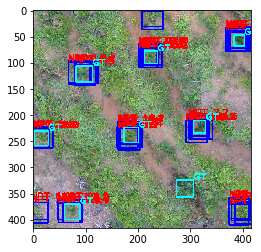

In [20]:
from matplotlib import pyplot as plt
import matplotlib

i = visualize_yolo(img_raw, torch_out, gt=gt, targetSize=416, conf_thresh=0.01)
plt.imshow(i)

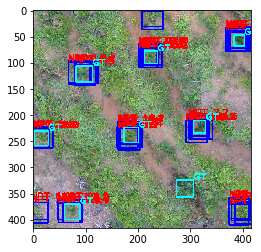

In [21]:
i = visualize_yolo(img_raw, ort_outs[0], gt=gt, targetSize=416, conf_thresh=0.01)
plt.imshow(i)


# Export

In [1]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "NOTEBOOK = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [2]:
!python notebook2script.py "$NOTEBOOK".ipynb

Traceback (most recent call last):
  File "notebook2script.py", line 75, in <module>
    if __name__ == '__main__': fire.Fire(notebook2script)
  File "/Users/ckh/anaconda3/lib/python3.6/site-packages/fire/core.py", line 138, in Fire
    component_trace = _Fire(component, args, parsed_flag_args, context, name)
  File "/Users/ckh/anaconda3/lib/python3.6/site-packages/fire/core.py", line 468, in _Fire
    target=component.__name__)
  File "/Users/ckh/anaconda3/lib/python3.6/site-packages/fire/core.py", line 672, in _CallAndUpdateTrace
    component = fn(*varargs, **kwargs)
  File "notebook2script.py", line 46, in notebook2script
    if not allFiles: notebook2scriptSingle(fname)
  File "notebook2script.py", line 57, in notebook2scriptSingle
    main_dic = json.load(open(fname,'r',encoding="utf-8"))
FileNotFoundError: [Errno 2] No such file or directory: '.ipynb'
